<a href="https://colab.research.google.com/github/Anusri-J/Live-PM2.5-Nowcast-and-Forecast/blob/main/Live_PM2_5_Nowcast_and_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data Acquisition**

In [51]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

In [52]:
# Provided the coordinates of location to scrape the data from Open-Meteo
lat, lon = 13.0827, 80.2707 # Chennai (change as needed)

In [53]:
# === Function to extract datetime and PM2.5 from Open-Meteo Air Quality ===
def fetch_openmeteo_pm25(lat, lon):
    """Fetch PM2.5 for the past 72 hours (3 days) from Open-Meteo Air Quality API."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()["hourly"]

    df = pd.DataFrame({
        "utc_time": pd.to_datetime(js["time"], utc=True),
        "pm25": js["pm2_5"]
    })
    # Keep only last 72 hours
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

In [54]:
# Saved the extracted data with dataframe named as pm25_data
pm25_data = fetch_openmeteo_pm25(lat, lon)

In [55]:
# Validated the count of pm25_data extracted from Open-Meteo Air Quality
print(f"Number of hours retrieved: {len(pm25_data)}")

Number of hours retrieved: 72


In [56]:
# Ensured on printing the data frame of pm25_data to validate the range
pm25_data

,utc_time,pm25
8,2025-10-24 08:00:00+00:00,10.0
9,2025-10-24 09:00:00+00:00,10.4
10,2025-10-24 10:00:00+00:00,10.8
11,2025-10-24 11:00:00+00:00,11.0
12,2025-10-24 12:00:00+00:00,10.9
...,...,...
75,2025-10-27 03:00:00+00:00,8.3
76,2025-10-27 04:00:00+00:00,7.9
77,2025-10-27 05:00:00+00:00,8.4
78,2025-10-27 06:00:00+00:00,9.4


In [57]:
# === Function to extract datetime and required variables from Open-Meteo Forecast ===
def fetch_openmeteo_weather(lat, lon):
    """Fetch hourly weather variables from Open-Meteo."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    hourly = r.json()["hourly"]
    df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
    for k, v in hourly.items():
        if k != "time":
            df[k] = v
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

In [58]:
# Saved the extracted data and print the count of extracted from Open-Meteo Forecast
whether_data = fetch_openmeteo_weather(lat, lon)
print(f"Number of hours retrieved: {len(whether_data)}")

Number of hours retrieved: 72


In [59]:
# Ensured on printing the data frame of whether_data to validate the range
whether_data

,utc_time,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure
8,2025-10-24 08:00:00+00:00,28.1,83,3.3,6,1006.8
9,2025-10-24 09:00:00+00:00,28.4,82,2.1,329,1005.6
10,2025-10-24 10:00:00+00:00,28.4,80,0.0,270,1005.0
11,2025-10-24 11:00:00+00:00,28.3,82,1.1,198,1005.0
12,2025-10-24 12:00:00+00:00,26.8,90,1.4,90,1006.1
...,...,...,...,...,...,...
75,2025-10-27 03:00:00+00:00,25.4,96,7.2,333,1009.1
76,2025-10-27 04:00:00+00:00,25.7,94,10.1,343,1009.4
77,2025-10-27 05:00:00+00:00,26.0,92,10.9,352,1008.5
78,2025-10-27 06:00:00+00:00,25.9,92,11.5,356,1007.8


In [60]:
# Merge pm25_data + whether_data (nearest timestamp, 1h tolerance)
merged = pd.merge_asof(
    pm25_data.sort_values("utc_time"),
    whether_data.sort_values("utc_time"),
    on="utc_time",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
    )

In [61]:
# Final data set after web scrape
merged

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure
0,2025-10-24 08:00:00+00:00,10.0,28.1,83,3.3,6,1006.8
1,2025-10-24 09:00:00+00:00,10.4,28.4,82,2.1,329,1005.6
2,2025-10-24 10:00:00+00:00,10.8,28.4,80,0.0,270,1005.0
3,2025-10-24 11:00:00+00:00,11.0,28.3,82,1.1,198,1005.0
4,2025-10-24 12:00:00+00:00,10.9,26.8,90,1.4,90,1006.1
...,...,...,...,...,...,...,...
67,2025-10-27 03:00:00+00:00,8.3,25.4,96,7.2,333,1009.1
68,2025-10-27 04:00:00+00:00,7.9,25.7,94,10.1,343,1009.4
69,2025-10-27 05:00:00+00:00,8.4,26.0,92,10.9,352,1008.5
70,2025-10-27 06:00:00+00:00,9.4,25.9,92,11.5,356,1007.8


**2) Feature Engineering**

**Lags (past snapshots)**



*   A lag is simply the value of a variable from a previous time step,like “PM2.5 one hour ago.”
*   It gives the model memory of the past, helping it learn trends and patterns over time.

In [62]:
# Selected lags 1–3 (short + long-term) for 24–48 hr predictions
pm_lags = [1,2,3]  # choose lags depending on forecast horizon
for lag in pm_lags:
    merged[f"pm25_lag{lag}"] = merged["pm25"].shift(lag)

**Rolling statistics (past trends)**

Rolling statistics summarize recent past values (like a 3-hour average) to show trends and smooth out noise, helping the model capture short-term patterns and stability.

In [63]:
# Selected rolling statistic(mean) 3–12 (short + long-term) for 24–48 hr predictions
merged['pm25_roll3'] = merged['pm25'].rolling(window=3).mean()
merged['pm25_roll6'] = merged['pm25'].rolling(window=6).mean()
merged['pm25_roll12'] = merged['pm25'].rolling(window=12).mean()

In [64]:
# Ensured target is shifted properly to predict next hour’s PM2.5
merged['target_pm25'] = merged['pm25'].shift(-1)

In [65]:
# Checked the data set after applying lags and rolling stats
merged

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll6,pm25_roll12,target_pm25
0,2025-10-24 08:00:00+00:00,10.0,28.1,83,3.3,6,1006.8,NaN,NaN,NaN,NaN,NaN,NaN,10.4
1,2025-10-24 09:00:00+00:00,10.4,28.4,82,2.1,329,1005.6,10.0,NaN,NaN,NaN,NaN,NaN,10.8
2,2025-10-24 10:00:00+00:00,10.8,28.4,80,0.0,270,1005.0,10.4,10.0,NaN,10.400000,NaN,NaN,11.0
3,2025-10-24 11:00:00+00:00,11.0,28.3,82,1.1,198,1005.0,10.8,10.4,10.0,10.733333,NaN,NaN,10.9
4,2025-10-24 12:00:00+00:00,10.9,26.8,90,1.4,90,1006.1,11.0,10.8,10.4,10.900000,NaN,NaN,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2025-10-27 03:00:00+00:00,8.3,25.4,96,7.2,333,1009.1,8.6,8.1,7.9,8.333333,8.283333,9.116667,7.9
68,2025-10-27 04:00:00+00:00,7.9,25.7,94,10.1,343,1009.4,8.3,8.6,8.1,8.266667,8.166667,8.900000,8.4
69,2025-10-27 05:00:00+00:00,8.4,26.0,92,10.9,352,1008.5,7.9,8.3,8.6,8.200000,8.200000,8.741667,9.4
70,2025-10-27 06:00:00+00:00,9.4,25.9,92,11.5,356,1007.8,8.4,7.9,8.3,8.566667,8.450000,8.691667,10.4


In [66]:
merged.bfill(inplace=True)
merged.ffill(inplace=True)

In [67]:
# Checked if any null values are present in dataset
merged.isna().sum()

,0
utc_time,0
pm25,0
temperature_2m,0
relativehumidity_2m,0
windspeed_10m,0
winddirection_10m,0
surface_pressure,0
pm25_lag1,0
pm25_lag2,0
pm25_lag3,0


In [68]:
# Checked the structure of dataset
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   utc_time             72 non-null     datetime64[ns, UTC]
 1   pm25                 72 non-null     float64            
 2   temperature_2m       72 non-null     float64            
 3   relativehumidity_2m  72 non-null     int64              
 4   windspeed_10m        72 non-null     float64            
 5   winddirection_10m    72 non-null     int64              
 6   surface_pressure     72 non-null     float64            
 7   pm25_lag1            72 non-null     float64            
 8   pm25_lag2            72 non-null     float64            
 9   pm25_lag3            72 non-null     float64            
 10  pm25_roll3           72 non-null     float64            
 11  pm25_roll6           72 non-null     float64            
 12  pm25_roll12          72 

**3) Anomaly Detection**

In [69]:
# Used IsolationForest algorithm to predict anamolies from dataset
from sklearn.ensemble import IsolationForest
features = ['pm25', 'temperature_2m', 'relativehumidity_2m', 'windspeed_10m', 'surface_pressure',
            'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'pm25_roll3', 'pm25_roll6', 'pm25_roll12', 'target_pm25']

X = merged[features]

# Initialize IsolationForest
iso = IsolationForest(
    n_estimators=100,      # number of trees
    contamination=0.05,    # fraction of expected anomalies (5% here)
    random_state=42
)

# Fit model
iso.fit(X)

# Predict anomalies
merged['anomaly'] = iso.predict(X)  # -1 = anomaly, 1 = normal

In [70]:
# Checked if any anamoly present in dataset
merged[merged['anomaly'] == -1]

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll6,pm25_roll12,target_pm25,anomaly
8,2025-10-24 16:00:00+00:00,27.5,26.1,93,1.6,207,1008.9,24.1,19.3,14.4,23.633333,17.866667,18.55,30.4,-1
9,2025-10-24 17:00:00+00:00,30.4,26.0,94,2.5,225,1008.7,27.5,24.1,19.3,27.333333,21.100000,18.55,28.8,-1
10,2025-10-24 18:00:00+00:00,28.8,25.5,98,2.2,189,1008.7,30.4,27.5,24.1,28.900000,24.083333,18.55,25.0,-1
11,2025-10-24 19:00:00+00:00,25.0,25.4,98,1.3,214,1007.9,28.8,30.4,27.5,28.066667,25.850000,18.55,23.8,-1


In [71]:
# merged['anomaly_flag'] = merged['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')
# merged

**4) Model Training**

In [72]:
# Defined Features and Target columns
# Target variable
y = merged['target_pm25']

# Feature variables (exclude utc_time and pm25 itself)
X = merged.drop(columns=['utc_time', 'pm25', 'target_pm25', 'anomaly'])

In [73]:
# Splited data into Train and Test (train_test_split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Used the first 80% for training and the last 20% for testing.

In [74]:
# Trained Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# model = GradientBoostingRegressor(
#     n_estimators=500,   # number of trees
#     learning_rate=0.01, # smaller = slower but more accurate
#     max_depth=5,        # depth of each tree
#     random_state=42
# )
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [75]:
# Evaluated model with metrics such as Mean Absolute Error, Mean Squared Error, R2 Score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 2.17
RMSE: 3.86
R²: 0.72


In [76]:
# Prediction of PM2.5 for next hour using the model
y_pred

array([10.21206274,  8.68610905, 20.91114919, 10.14085419,  7.78986229,
        7.85834776, 29.27543225,  7.00523661, 24.12109844,  9.48224251,
        6.97078781,  7.34110909, 29.28460889,  6.78220587, 10.17245008])

In [77]:
# Converted the model into byte stream(binary) form using pickling
import pickle
pickle.dump(model,open("Whether.pkl","wb"))

In [78]:
# Taken a copy of last row features to feed input for predictions
last_row = merged.iloc[-1].copy()  # Copy the last row as starting point

**5) Forecasting**

In [79]:
# ✅ Recursive Prediction Loop (feature-safe)
forecast_hours = 48
predictions = []

# List of features used during model training
model_features = model.feature_names_in_  # sklearn models store this after fitting

for i in range(forecast_hours):
    # 1️⃣ Prepare input row with only model features
    X_input = last_row[model_features].to_frame().T  # keep 2D shape

    # 2️⃣ Predict
    y_pred = model.predict(X_input)[0]
    predictions.append(y_pred)

    # 3️⃣ Update lag features
    last_row['pm25_lag3'] = last_row['pm25_lag2']
    last_row['pm25_lag2'] = last_row['pm25_lag1']
    last_row['pm25_lag1'] = y_pred

    # 4️⃣ Update rolling statistics
    last_row['pm25_roll3'] = np.mean([last_row['pm25_lag1'],
                                      last_row['pm25_lag2'],
                                      last_row['pm25_lag3']])
    last_row['pm25_roll6'] = (last_row.get('pm25_roll6', y_pred) * 5 + y_pred) / 6
    last_row['pm25_roll12'] = (last_row.get('pm25_roll12', y_pred) * 11 + y_pred) / 12

    # 5️⃣ Increment timestamp safely
    if 'utc_time' in last_row:
        if not isinstance(last_row['utc_time'], pd.Timestamp):
            last_row['utc_time'] = pd.to_datetime(last_row['utc_time'])
        last_row['utc_time'] += pd.Timedelta(hours=1)

print(f"✅ Forecast completed for {forecast_hours} hours.")

✅ Forecast completed for 48 hours.


In [80]:
# Create Forecast DataFrame
forecast_times = [merged['utc_time'].iloc[-1] + pd.Timedelta(hours=i+1) for i in range(forecast_hours)]
forecast_df = pd.DataFrame({
    'utc_time': forecast_times,
    'pm25_pred': predictions
})

In [81]:
# Checked the output of predictions upto 48 hrs
forecast_df

,utc_time,pm25_pred
0,2025-10-27 08:00:00+00:00,10.411632
1,2025-10-27 09:00:00+00:00,9.979227
2,2025-10-27 10:00:00+00:00,9.788210
3,2025-10-27 11:00:00+00:00,9.825673
4,2025-10-27 12:00:00+00:00,9.793850
5,2025-10-27 13:00:00+00:00,9.793850
6,2025-10-27 14:00:00+00:00,9.793850
7,2025-10-27 15:00:00+00:00,9.793850
8,2025-10-27 16:00:00+00:00,9.793850
9,2025-10-27 17:00:00+00:00,9.846595


**6) Visualization**

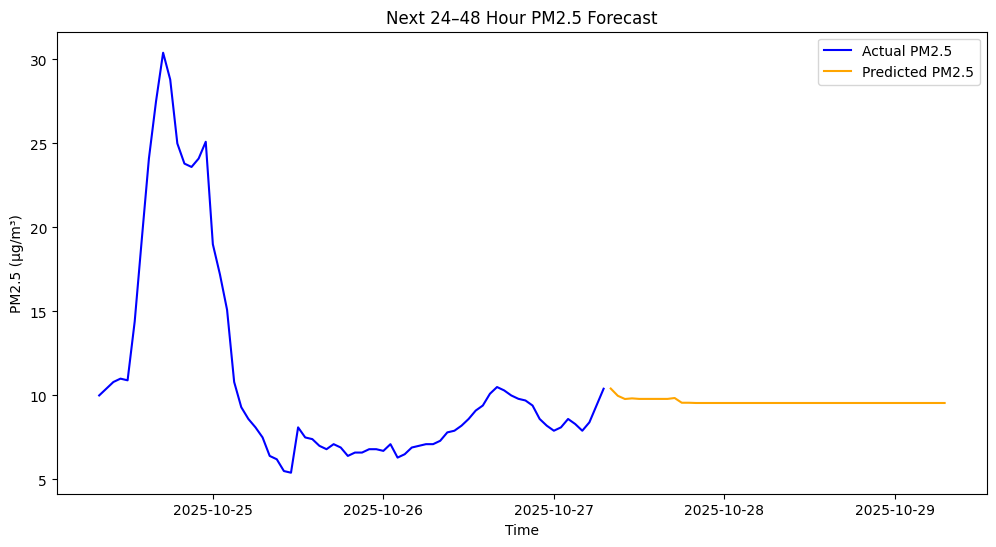

In [82]:
# Visualized Predictions vs Actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged['utc_time'], merged['pm25'], label='Actual PM2.5', color='blue')
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')
plt.title('Next 24–48 Hour PM2.5 Forecast')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

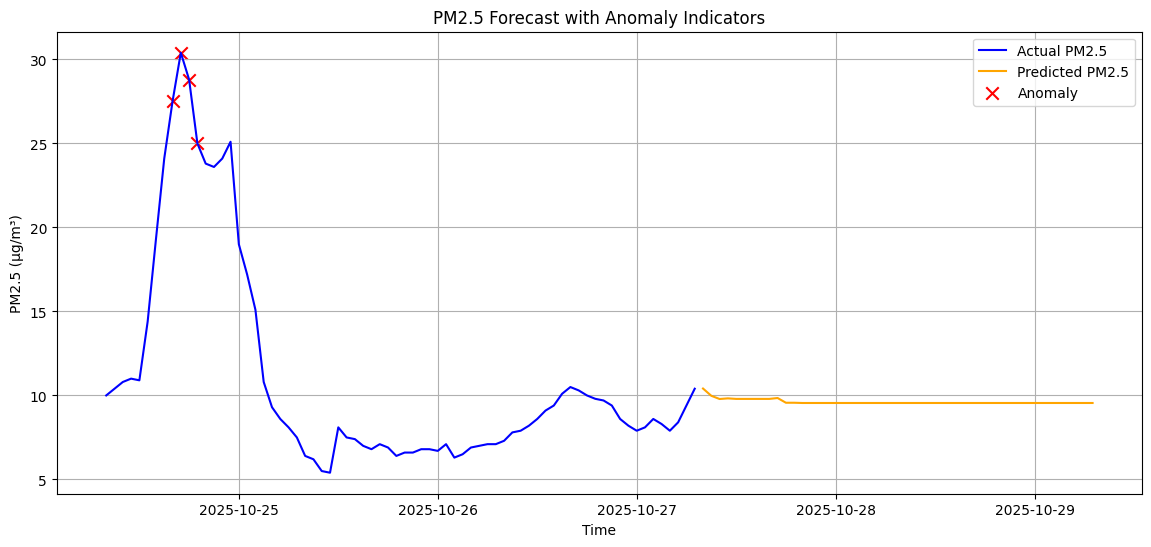

In [83]:
# Visualized Predictions vs Actual with Anomalies
plt.figure(figsize=(14,6))

# Plot historical PM2.5
plt.plot(merged['utc_time'], merged['pm25'], label='Actual PM2.5', color='blue')

# Plot forecasted PM2.5
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')

# Highlight anomalies in historical data
anomaly_points = merged[merged['anomaly'] == -1]
plt.scatter(anomaly_points['utc_time'], anomaly_points['pm25'],
            color='red', label='Anomaly', marker='x', s=80)

plt.title('PM2.5 Forecast with Anomaly Indicators')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

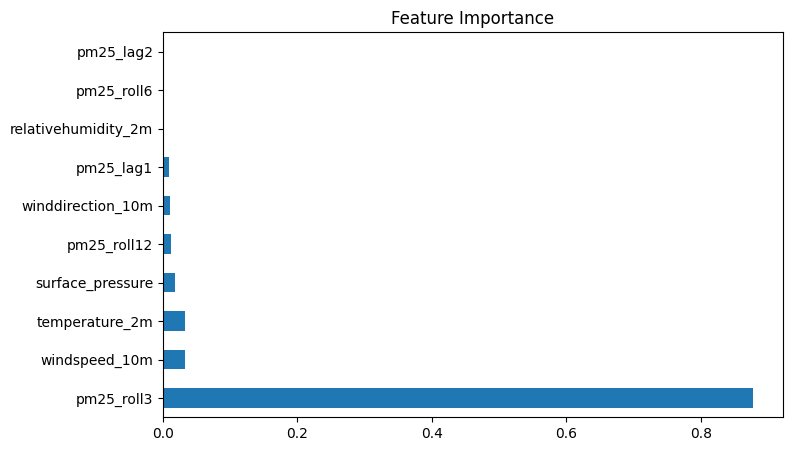

In [84]:
# Feature Importance Analysis - Check which lags or rolling averages are most important
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh', title='Feature Importance', figsize=(8,5))
plt.show()

In [88]:
!pip install streamlit

In [86]:
!pip install streamlit streamlit_option_menu

In [93]:
%%writefile app.py

import warnings
# Suppress Streamlit ScriptRunContext warning in bare mode
warnings.filterwarnings("ignore", message="Thread 'MainThread': missing ScriptRunContext!")

import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta, timezone
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def main():
    import streamlit as st  # Import inside main() for Streamlit context

    st.set_page_config(page_title="PM2.5 Forecast & Anomaly Detection", layout="wide")
    st.title("🟢 PM2.5 Forecasting & Anomaly Detection (No Visuals)")

    # ===============================
    # Sidebar Inputs
    # ===============================
    st.sidebar.header("📍 Location Input")
    lat = st.sidebar.number_input("Latitude", value=13.0827)
    lon = st.sidebar.number_input("Longitude", value=80.2707)
    forecast_hours = st.sidebar.slider("Forecast Hours", min_value=1, max_value=48, value=24)

    # ===============================
    # Fetch Functions
    # ===============================
    def fetch_openmeteo_pm25(lat, lon):
        end_date = datetime.now(timezone.utc)
        start_date = end_date - timedelta(hours=72)
        url = "https://air-quality-api.open-meteo.com/v1/air-quality"
        params = {
            "latitude": lat,
            "longitude": lon,
            "hourly": "pm2_5",
            "start_date": start_date.strftime("%Y-%m-%d"),
            "end_date": end_date.strftime("%Y-%m-%d"),
            "timezone": "UTC"
        }
        r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        js = r.json()["hourly"]
        df = pd.DataFrame({
            "utc_time": pd.to_datetime(js["time"], utc=True),
            "pm25": js["pm2_5"]
        })
        df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
        return df

    def fetch_openmeteo_weather(lat, lon):
        end_date = datetime.now(timezone.utc)
        start_date = end_date - timedelta(hours=72)
        url = "https://api.open-meteo.com/v1/forecast"
        params = {
            "latitude": lat,
            "longitude": lon,
            "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,surface_pressure",
            "start_date": start_date.strftime("%Y-%m-%d"),
            "end_date": end_date.strftime("%Y-%m-%d"),
            "timezone": "UTC"
        }
        r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        hourly = r.json()["hourly"]
        df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
        for k, v in hourly.items():
            if k != "time":
                df[k] = v
        df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
        return df

    # ===============================
    # Fetch and Merge Data
    # ===============================
    with st.spinner("Fetching PM2.5 and weather data..."):
        pm25_data = fetch_openmeteo_pm25(lat, lon)
        weather_data = fetch_openmeteo_weather(lat, lon)

    merged = pd.merge_asof(
        pm25_data.sort_values("utc_time"),
        weather_data.sort_values("utc_time"),
        on="utc_time",
        direction="nearest",
        tolerance=pd.Timedelta("1h")
    )

    # ===============================
    # Feature Engineering
    # ===============================
    for lag in [1, 2, 3]:
        merged[f"pm25_lag{lag}"] = merged["pm25"].shift(lag)

    merged['pm25_roll3'] = merged['pm25'].rolling(window=3).mean()
    merged['pm25_roll6'] = merged['pm25'].rolling(window=6).mean()
    merged['pm25_roll12'] = merged['pm25'].rolling(window=12).mean()
    merged['target_pm25'] = merged['pm25'].shift(-1)
    merged.bfill(inplace=True)
    merged.ffill(inplace=True)

    # ===============================
    # Anomaly Detection
    # ===============================
    features_iso = [
        'pm25', 'temperature_2m', 'relativehumidity_2m', 'windspeed_10m',
        'surface_pressure', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
        'pm25_roll3', 'pm25_roll6', 'pm25_roll12', 'target_pm25'
    ]

    iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso.fit(merged[features_iso])
    merged['anomaly'] = iso.predict(merged[features_iso])

    # ===============================
    # Model Training
    # ===============================
    y = merged['target_pm25']
    X = merged.drop(columns=['utc_time', 'pm25', 'target_pm25', 'anomaly'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    st.subheader("📊 Model Performance Metrics")
    st.write(f"**MAE:** {mae:.2f}")
    st.write(f"**RMSE:** {rmse:.2f}")
    st.write(f"**R² Score:** {r2:.2f}")

    # ===============================
    # Recursive Forecast
    # ===============================
    last_row = merged.iloc[-1].copy()
    predictions = []
    model_features = model.feature_names_in_

    for i in range(forecast_hours):
        X_input = last_row[model_features].to_frame().T
        y_pred = model.predict(X_input)[0]
        predictions.append(y_pred)

        # Update lag features
        last_row['pm25_lag3'] = last_row['pm25_lag2']
        last_row['pm25_lag2'] = last_row['pm25_lag1']
        last_row['pm25_lag1'] = y_pred

        # Update rolling statistics
        last_row['pm25_roll3'] = np.mean([
            last_row['pm25_lag1'], last_row['pm25_lag2'], last_row['pm25_lag3']
        ])
        last_row['pm25_roll6'] = (last_row['pm25_roll6'] * 5 + y_pred) / 6
        last_row['pm25_roll12'] = (last_row['pm25_roll12'] * 11 + y_pred) / 12

        # Increment timestamp
        last_row['utc_time'] += pd.Timedelta(hours=1)

    forecast_times = [
        merged['utc_time'].iloc[-1] + pd.Timedelta(hours=i + 1)
        for i in range(forecast_hours)
    ]
    forecast_df = pd.DataFrame({
        'utc_time': forecast_times,
        'pm25_pred': predictions
    })

    # ===============================
    # Display Data
    # ===============================
    st.subheader("🗂️ Historical PM2.5 & Weather Data")
    st.dataframe(merged.tail(20))

    st.subheader("🗂️ Forecasted PM2.5 for Next Hours")
    st.dataframe(forecast_df)


# ✅ Main guard — now outside the function
if __name__ == "__main__":
    main()

Overwriting app.py


In [94]:
#Install required packages
!pip install streamlit pyngrok sqlalchemy mysql-connector-python pandas

# Set up ngrok for tunneling
from pyngrok import ngrok, conf

# Get your ngrok authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_AUTHTOKEN = "32BsMiyHQoLDzV3kRSzHEVwFemY_5MmfskRqVADWi18d76NGo"
# Set the auth token
conf.get_default().auth_token = NGROK_AUTHTOKEN

In [95]:
import subprocess
import time
import threading

# Kill any existing Streamlit processes
!kill -9 $(pgrep ngrok)

# Function to run Streamlit
def run_streamlit():
    !streamlit run app.py --server.port 8501 --server.enableCORS false --server.enableXsrfProtection false

# Start Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

# Wait for Streamlit to start
time.sleep(5)

# Create a tunnel to the Streamlit port using the correct method
public_url = ngrok.connect(addr="8501", proto="http", bind_tls=True)
print("Your Streamlit app is available at:", public_url.public_url)



2025-10-27 08:00:37.288 Port 8501 is already in use
Your Streamlit app is available at: https://75781fbe2970.ngrok-free.app
